## Graph Density -> overlap score and cosine similarity score mean dist

In [4]:
import torch
import numpy as np
import random
import torch.nn as nn
import torch.nn.functional as F

import networkx as nx
from itertools import combinations
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
    
SEED = 42
print("device:", device)

device: mps


In [6]:
def get_erdos_network(N: int, density: float) -> nx.Graph:
    edge_num = int(N*(N-1)/2 * density)
    graph = nx.gnm_random_graph(N, edge_num, SEED)
    return graph

In [23]:
class GraphSageLayer(nn.Module):

    def __init__(self, dim_in: int, dim_out: int):
        super(GraphSageLayer, self).__init__()

        self.dim_in = dim_in
        self.dim_out = dim_out
        self.act = nn.ReLU()

        self.weight = nn.Parameter(data=torch.zeros((dim_in, dim_out), device=device), requires_grad=False)
        nn.init.xavier_uniform_(self.weight)

    def forward(self, feat: torch.Tensor,
                adjacency: torch.Tensor,
                activate: bool) -> torch.Tensor:
        
        num_nodes = feat.shape[0]
        adj_eye = adjacency + torch.eye(num_nodes, device=device)
        degree = torch.sum(adj_eye, dim=1)
        dgr_inv = torch.diag(1/degree)
        
        laplace_sym = dgr_inv @ adj_eye
        out = laplace_sym @ feat @ self.weight
        if activate:
            out = self.act(out)
        
        return out
    
class GraphSage(nn.Module):

    def __init__(self, num_layers: int,
                 dim_in: int,
                 dim_hidden: int,
                 dim_out: int):

        super(GraphSage, self).__init__()

        self.num_layers = num_layers
        self.dim_in = dim_in
        self.dim_hidden = dim_hidden
        self.dim_out = dim_out

        self.layers = nn.ModuleList()
        for l in range(num_layers):
            self.layers.append(GraphSageLayer(self.dim_in if l == 0 else self.dim_hidden, self.dim_hidden if l < num_layers-1 else self.dim_out))


    def forward(self, feat: torch.Tensor,
                adj: torch.Tensor) -> torch.Tensor:

        x_in = feat
        for layer in self.layers:
            x_out = layer(x_in, adj, (False if self.layers[-1] == layer else True))
            x_in = x_out

        return x_out

In [21]:
k_hop_neighbor_dict = defaultdict(list)    

def get_k_neighbor_list(G: nx.Graph, k: int) -> None:
    return [set(nx.ego_graph(G, node, k)) for node in G.nodes]


def measure_neighbor_overlap(G: nx.Graph, k: int):
    neighbor_list = np.array(get_k_neighbor_list(G, k))
    num_node = len(neighbor_list)

    def overlap(i, j) : # NODE i & NODE j
        neighbor_i: set = neighbor_list[i]
        neighbor_j: set = neighbor_list[j]
        Inter_ij = neighbor_i.intersection(neighbor_j)
        len_union_ij = len(neighbor_i) + len(neighbor_j) - len(Inter_ij)
        return len(Inter_ij) / len_union_ij

    overlap_vec = np.vectorize(overlap)

    node_comb = combinations(range(num_node), 2)
    i, j = np.array(list(node_comb)).T
    overlap_scores = overlap_vec(i, j)
    return np.mean(overlap_scores)


In [9]:
def measure_node_smoothness(features: np.ndarray) -> np.ndarray:
    
    def compute_sim(i, j):
        x, y = features[i, :], features[j, :]
        return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))
        
    compute_sim_vec = np.vectorize(compute_sim)
    
    n = features.shape[0]
    node_comb = combinations(range(n), 2)
    i, j = np.array(list(node_comb)).T
    similarities = compute_sim_vec(i, j)
    mean_score = np.mean(np.abs(similarities))
    return mean_score



In [58]:
def get_score(N, density, layers):
    graph = get_erdos_network(N, density)
    scoring = defaultdict(list)

    for k in tqdm(layers):
        neighbor_overlap = measure_neighbor_overlap(graph, k)
        model = GraphSage(k, N, N//2, N//2)
        embedding = torch.eye(N, device=device)
        adj: torch.Tensor = torch.from_numpy(nx.adjacency_matrix(graph).toarray()).to(device)
        feature = model(embedding, adj).cpu()
        smoothness = measure_node_smoothness(feature)
        scoring["overlap"].append(neighbor_overlap)
        scoring["smoothness"].append(smoothness)
    return scoring


100%|██████████| 10/10 [00:00<00:00, 17.72it/s]


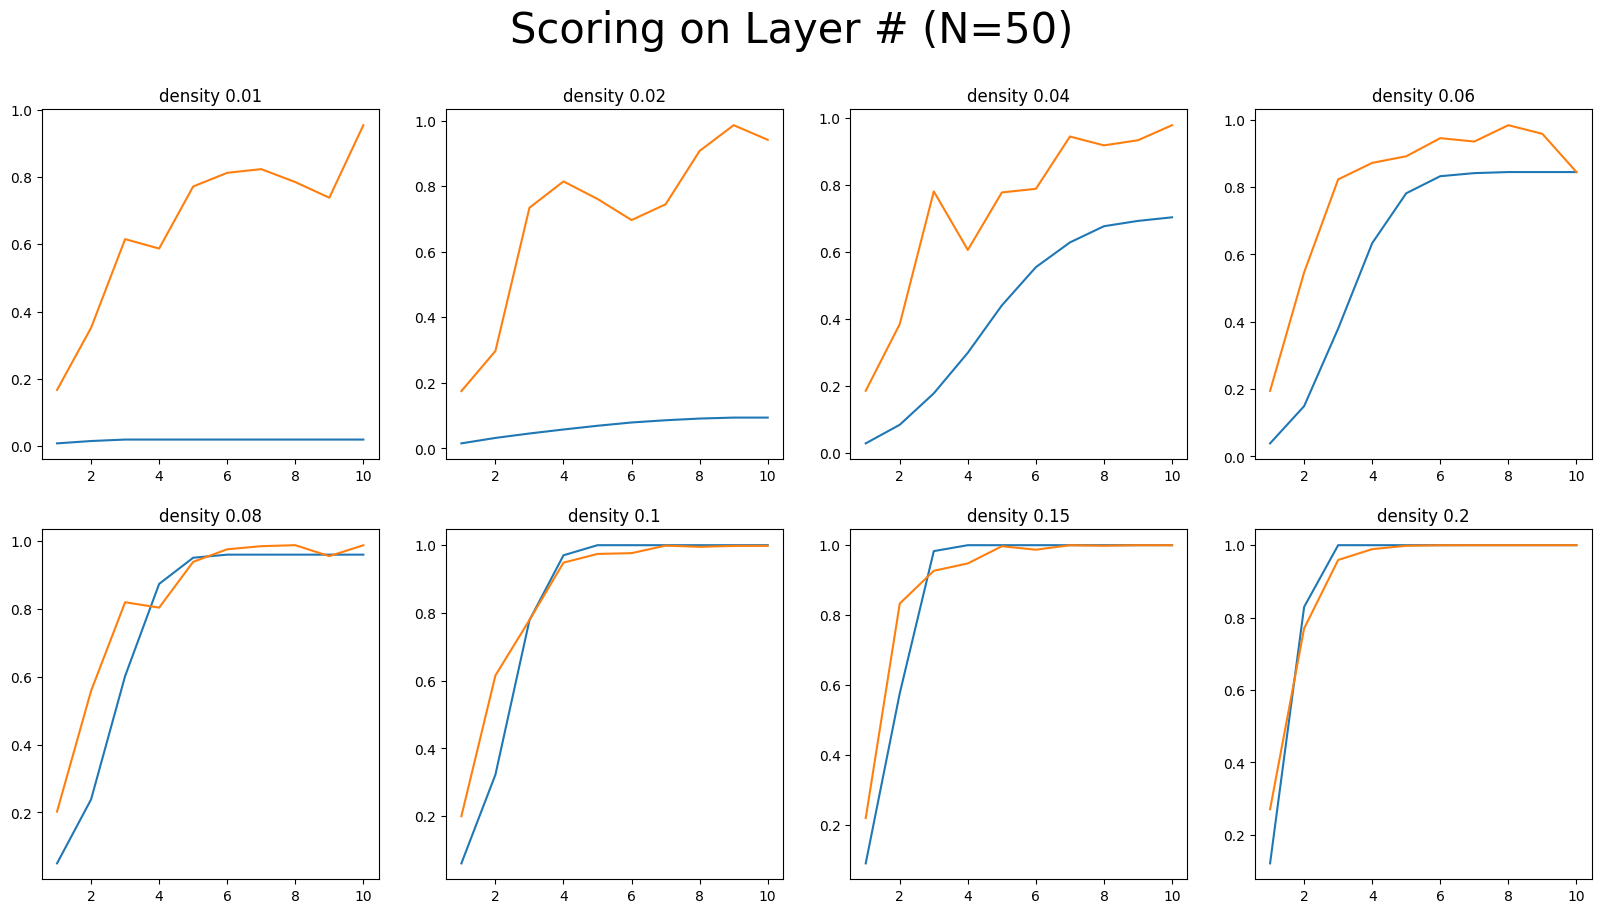

 50%|█████     | 5/10 [00:00<00:00,  6.53it/s]


KeyboardInterrupt: 

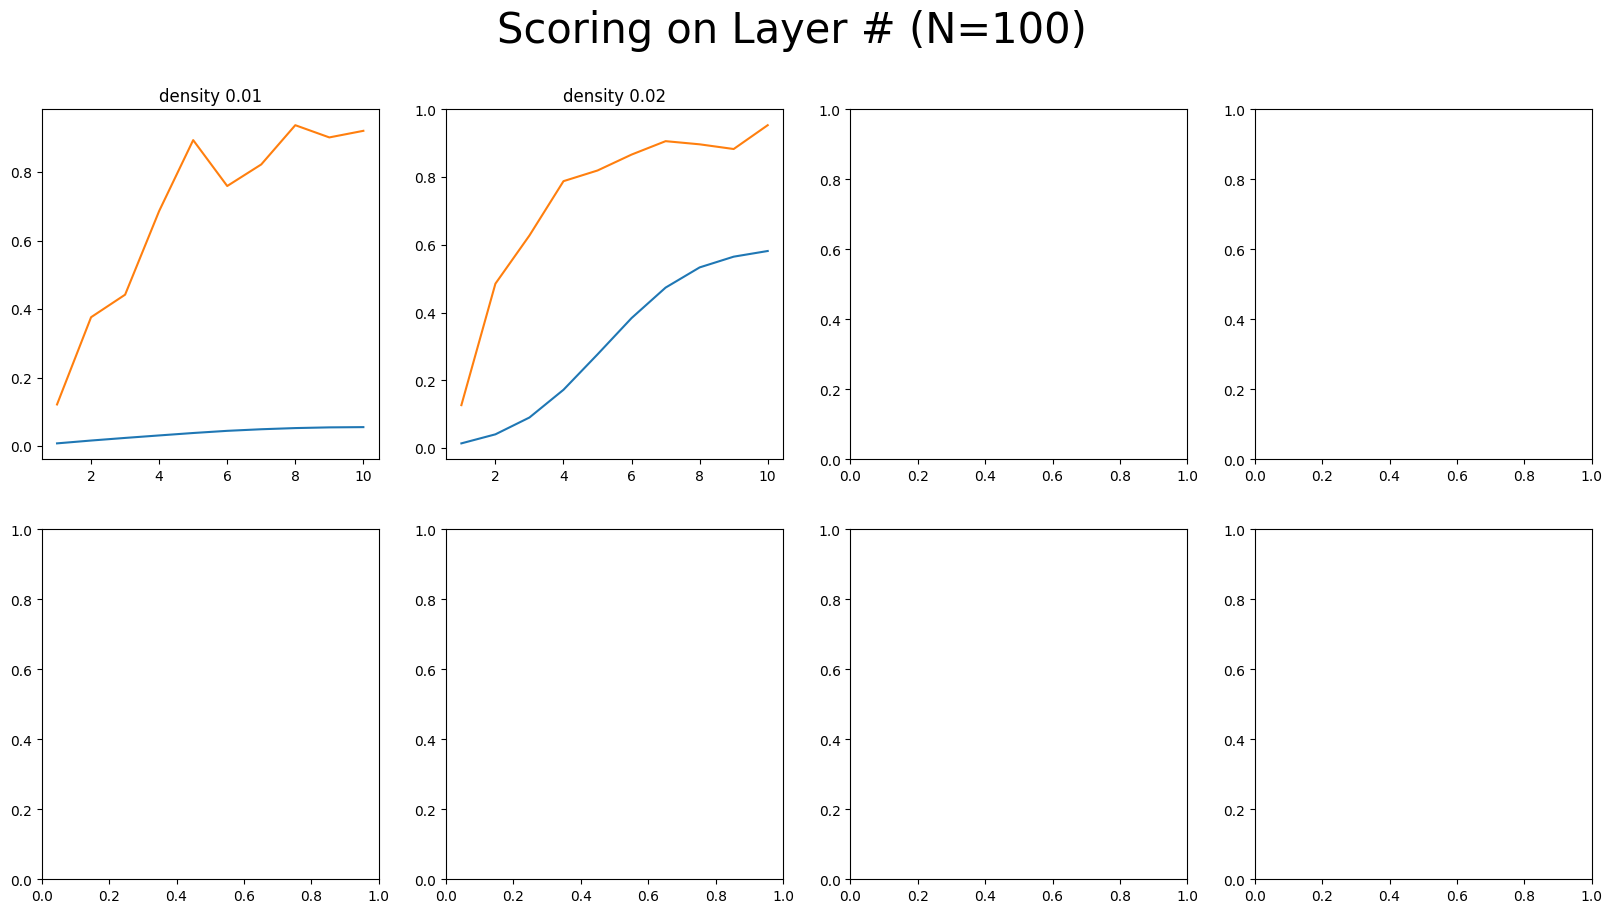

In [80]:
N_list = [50, 100, 250, 500]
dense_list = [0.01, 0.02, 0.04, 0.06, 0.08, 0.1, 0.15, 0.2]
LAYERS = list(range(1, 11))

for N in N_list:
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    plt.suptitle(f"Scoring on Layer # (N={N})", fontsize = 30)
    for i, dense in enumerate(dense_list):
        ax = axes[divmod(i, 4)]
        scoring = get_score(N, dense, LAYERS)
        ax.set_title(f"density {dense}")
        overlap = ax.plot(LAYERS, scoring["overlap"], label="overlap")
        smooth = ax.plot(LAYERS, scoring["smoothness"], label="smoothness")
    plt.savefig(f"node {N}.png")
    plt.show()

